# LAPLACE APPROXIMATION

In [51]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import inv
from scipy.optimize import approx_fprime

# Given covariance matrix and its inverse
sigma = np.array([[1, 0.9], [0.9, 1]])
sigma_inv = np.linalg.inv(sigma)

# Define the log-posterior function
def log_posterior(x):
    x1, x2 = x
    first_term = x.T @ sigma_inv @ x
    second_term = (x2 + (x1**2 + 1))**2
    return 0.5 * first_term + 0.5 * second_term

# Initial guess for optimization
x0 = np.array([0.0, 0.0])
initial_guess = np.random.randn((2)) # random guess
print("Initial Guess: {}".format(initial_guess))


# Use scipy.optimize.minimize to find the MAP estimate
result = minimize(log_posterior, initial_guess, method='BFGS')

# Extract the MAP estimate
map_estimate = result.x

print("MAP estimate:", map_estimate)
print("Function value at MAP:", result.fun)

if hasattr(result, 'hess_inv') and isinstance(result.hess_inv, np.ndarray):
    # Use the Hessian inverse if provided by the optimizer
    hessian_inv = result.hess_inv
else:
    # Use finite differences to approximate the Hessian
    epsilon = np.sqrt(np.finfo(float).eps)
    hessian = np.zeros((len(map_estimate), len(map_estimate)))
    for i in range(len(map_estimate)):
        def func_i(x):
            print("DEBUG {}".format(x))
            params = map_estimate.copy()
            params[i] = x
            return negative_log_posterior(params)
        grad = approx_fprime(map_estimate, func_i, epsilon)
        hessian[i, :] = grad
    # Invert the Hessian to get the covariance
    hessian_inv = inv(hessian)

map_cov = hessian_inv
print("Approximate Covariance Matrix from Laplace Approximation:\n", map_cov)

Initial Guess: [-0.92067305 -0.87613002]
MAP estimate: [-0.26245689 -0.36915888]
Function value at MAP: 0.3257625473183594
Approximate Covariance Matrix from Laplace Approximation:
 [[0.40956674 0.34610599]
 [0.34610599 0.45244615]]


In [52]:
import numpy as np

class MetropolisHastings:

    def __init__(self, logpdf, proposal_std=2.0, max_samples=10000):
        self.logpdf = logpdf
        self.proposal_std = proposal_std
        self.max_samples = max_samples
        self.samples = []
        self.accepted = 0  # Counter for accepted samples

    def sample(self, initial_sample, num_samples):
        assert num_samples <= self.max_samples, "Requesting more samples than allowed."

        # Initialize the Markov chain
        current_sample = np.array(initial_sample)
        self.samples.append(current_sample)
        current_logpdf = self.logpdf(current_sample)

        for i in range(1, num_samples):
            # Propose a new sample
            proposal = current_sample + np.random.normal(0, self.proposal_std, size=current_sample.shape)
            proposal_logpdf = self.logpdf(proposal)

            # Compute the acceptance probability
            acceptance_ratio = np.exp(proposal_logpdf - current_logpdf)
            if np.random.rand() < acceptance_ratio:
                # Accept the proposal
                current_sample = proposal
                current_logpdf = proposal_logpdf
                self.accepted += 1

            # Store the sample
            self.samples.append(current_sample)

            if i % 1000 == 0:
                print(f"Sample {i}, acceptance ratio = {self.accepted / i}")

        return np.array(self.samples)


Sample 1000, acceptance ratio = 0.253
Sample 2000, acceptance ratio = 0.253
Sample 3000, acceptance ratio = 0.24866666666666667
Sample 4000, acceptance ratio = 0.2495
Sample 5000, acceptance ratio = 0.2506
Sample 6000, acceptance ratio = 0.25166666666666665
Sample 7000, acceptance ratio = 0.2517142857142857
Sample 8000, acceptance ratio = 0.250625
Sample 9000, acceptance ratio = 0.24911111111111112


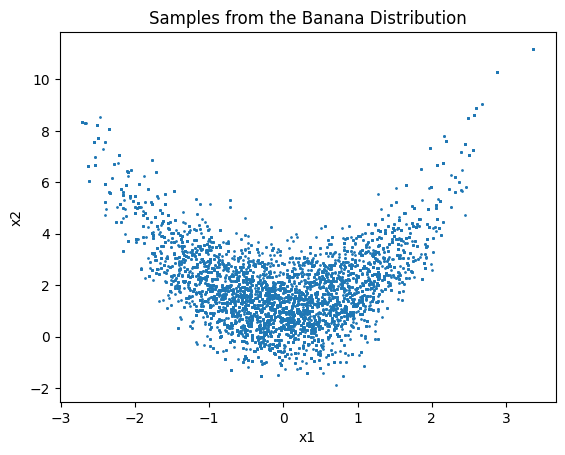

In [53]:
# Define the logpdf for the banana distribution
def banana_logpdf(x):
    """Log probability density function of the banana distribution."""
    x1, x2 = x[0], x[1]

    # Log of the probability density
    log_pdf = -0.5 * (x1**2 + (x2 - (x1**2 + 1))**2)

    return log_pdf

# Initial sample and covariance matrix
initial_sample = map_estimate
cov_matrix = map_cov

# Create the Adaptive Metropolis sampler
sampler = MetropolisHastings(logpdf=banana_logpdf)

# Generate samples from the banana distribution
num_samples = 10000
samples = sampler.sample(initial_sample, num_samples)
samples_MH = samples[2000:]

# Plot the results
import matplotlib.pyplot as plt

plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.title("Samples from the Banana Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


# ADAPTIVE METROPOLIS

In [54]:
import numpy as np
class AdaptiveMetropolis:

    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7):
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        self.mean = np.zeros(self.dim)  # running mean of samples
        self.cov_sum = np.zeros((self.dim, self.dim))  # sum for covariance calculation

    def sample(self, initial_sample, num_samples):

        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"

        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)

        accept = 1
        for ii in range(1, num_samples):

            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)

            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)

            u = np.random.rand()
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                self.samples[ii, :] = self.samples[ii-1, :]
                self.logpdf_vals[ii] = self.logpdf_vals[ii-1]

            self.num_samples += 1

            if ii > self.t0 and ii % self.freq == 0:
                subset = self.samples[:self.num_samples] # Getting the added samples
                centered = subset - np.mean(subset, axis=0) # Finding the difference (X_i-X_mean)
                sample_cov = (centered.T @ centered) / (self.num_samples - 1) # Calculating the covariance using matrix multiplication directly
                self.cov = self.sd * (sample_cov + self.eps * np.identity(self.dim))  # Updating the covariance incrementally
                self.cov_chol = np.linalg.cholesky(self.cov)

            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")

        return self.samples

Finished sample 1000, acceptance ratio = 0.261
Finished sample 2000, acceptance ratio = 0.2455
Finished sample 3000, acceptance ratio = 0.23733333333333334
Finished sample 4000, acceptance ratio = 0.23225
Finished sample 5000, acceptance ratio = 0.2314
Finished sample 6000, acceptance ratio = 0.23633333333333334
Finished sample 7000, acceptance ratio = 0.231
Finished sample 8000, acceptance ratio = 0.229375
Finished sample 9000, acceptance ratio = 0.22866666666666666


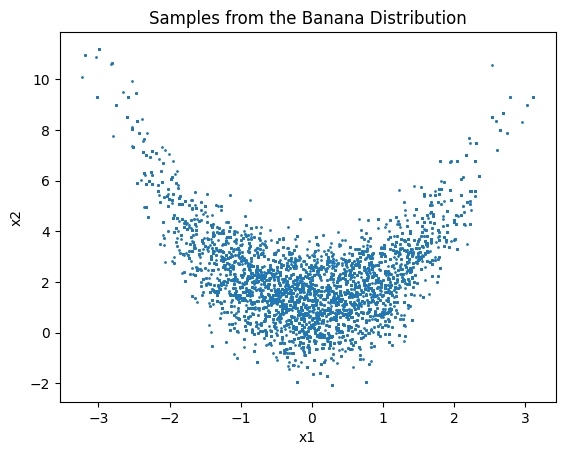

In [55]:
# Define the logpdf for the banana distribution
def banana_logpdf(x):
    """Log probability density function of the banana distribution."""
    x1, x2 = x[0], x[1]

    # Log of the probability density
    log_pdf = -0.5 * (x1**2 + (x2 - (x1**2 + 1))**2)

    return log_pdf

# Initial sample and covariance matrix
initial_sample = map_estimate
cov_matrix = map_cov

# Create the Adaptive Metropolis sampler
sampler = AdaptiveMetropolis(logpdf=banana_logpdf, cov=cov_matrix, t0=100, freq=10)

# Generate samples from the banana distribution
num_samples = 10000
samples = sampler.sample(initial_sample, num_samples)
samples_AM = samples[2000:]

# Plot the results
import matplotlib.pyplot as plt

plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.title("Samples from the Banana Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


# DELAYED REJECTION ALGORITHM

In [56]:
import numpy as np

class DelayedRejection:

    def __init__(self, logpdf, cov, gamma=0.5, sd1=None, sd2=None, max_samples=10000, eps=1e-7):
        self.logpdf = logpdf
        self.cov1 = cov
        self.cov2 = gamma * cov  # Second level proposal with scaled covariance
        self.cov1_chol = np.linalg.cholesky(self.cov1)
        self.cov2_chol = np.linalg.cholesky(self.cov2)
        self.dim = cov.shape[0]
        self.sd1 = sd1 if sd1 is not None else (2.4**2) / self.dim
        self.sd2 = sd2 if sd2 is not None else (2.4**2) / self.dim
        self.max_samples = max_samples
        self.eps = eps
        self.num_samples = 0
        self.samples = np.zeros((max_samples, self.dim))
        self.logpdf_vals = np.zeros(max_samples)

    def sample(self, initial_sample, num_samples):
        assert num_samples <= self.max_samples, "Requesting more samples than space allocated."

        # Initialize the first sample
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
        accept = 1

        # Main MCMC loop
        for ii in range(1, num_samples):
            # First proposal
            y1 = self.samples[ii - 1, :] + np.dot(self.cov1_chol, np.random.randn(self.dim))
            y1_logpdf = self.logpdf(y1)
            a1 = np.exp(y1_logpdf - self.logpdf_vals[ii - 1])
            a1 = min(a1, 1)

            # Accept or move to second proposal
            if np.random.rand() < a1:  # Accept first proposal
                self.samples[ii, :] = y1
                self.logpdf_vals[ii] = y1_logpdf
                accept += 1
            else:  # First proposal rejected, try second proposal
                # Second proposal
                y2 = self.samples[ii - 1, :] + np.dot(self.cov2_chol, np.random.randn(self.dim))
                y2_logpdf = self.logpdf(y2)

                # Compute acceptance probability for the second proposal
                a2_numerator = np.exp(y2_logpdf - self.logpdf_vals[ii - 1]) * (1 - a1)
                a2_denominator = np.exp(y2_logpdf - y1_logpdf) * (1 - a1) + self.eps
                a2 = min(a2_numerator / a2_denominator, 1)

                if np.random.rand() < a2:  # Accept second proposal
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y2_logpdf
                    accept += 1
                else:  # Reject both proposals
                    self.samples[ii, :] = self.samples[ii - 1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii - 1]

            self.num_samples += 1

            # Progress update
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")

        return self.samples


Finished sample 1000, acceptance ratio = 0.673
Finished sample 2000, acceptance ratio = 0.696
Finished sample 3000, acceptance ratio = 0.6996666666666667
Finished sample 4000, acceptance ratio = 0.71075
Finished sample 5000, acceptance ratio = 0.72
Finished sample 6000, acceptance ratio = 0.7203333333333334
Finished sample 7000, acceptance ratio = 0.725
Finished sample 8000, acceptance ratio = 0.729
Finished sample 9000, acceptance ratio = 0.7318888888888889


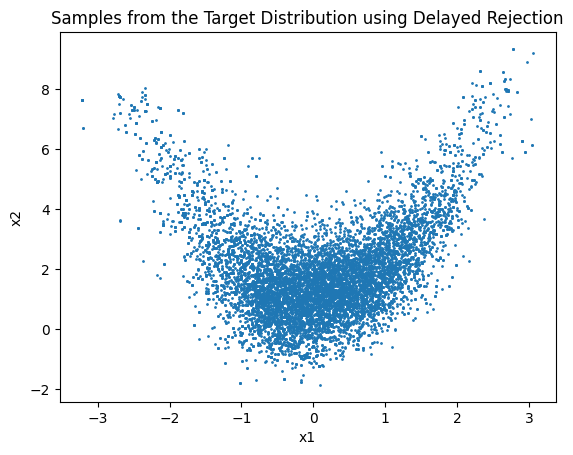

In [57]:
# Define the logpdf for the banana distribution
def target_logpdf(x):
    """Log probability density function of the banana distribution."""
    x1, x2 = x[0], x[1]

    # Log of the probability density
    log_pdf = -0.5 * (x1**2 + (x2 - (x1**2 + 1))**2)

    return log_pdf

# Initial sample and covariance matrix
initial_sample = map_estimate
cov_matrix = map_cov

# Create the Delayed Rejection Adaptive Metropolis sampler
gamma = 0.5  # Scale for the second level proposal
sampler = DelayedRejection(logpdf=target_logpdf, cov=cov_matrix, gamma=gamma)

# Generate samples from the target distribution
num_samples = 10000
samples = sampler.sample(initial_sample, num_samples)
samples_DR = samples[2000:]

# Plot the results
import matplotlib.pyplot as plt

plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.title("Samples from the Target Distribution using Delayed Rejection")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


# DRAM

In [58]:
class DelayedRejectionAdaptiveMetropolis(AdaptiveMetropolis):

    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7, gamma=0.5):
        """
        The constructor initializes the class with an additional `gamma` parameter, which controls the reduction in covariance
        for the second level of the proposal.
        """
        super().__init__(logpdf, cov, t0, freq, sd, max_samples, eps)
        self.gamma = gamma  # The factor by which covariance is reduced for the second level of proposals

    def sample(self, initial_sample, num_samples):
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"

        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)

        accept = 1
        for ii in range(1, num_samples):
            # First, propose from the high-level proposal (covariance C)
            y1 = self.samples[ii - 1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y1_logpdf = self.logpdf(y1)

            # Calculate acceptance probability for high-level proposal
            a1 = np.exp(y1_logpdf - self.logpdf_vals[ii - 1])
            a1 = min(a1, 1)

            u = np.random.rand()
            if u < a1:  # Accept the high-level proposal
                self.samples[ii, :] = y1
                self.logpdf_vals[ii] = y1_logpdf
                accept += 1
            else:
                # If high-level proposal is rejected, propose from the low-level proposal (covariance γC)
                y2 = self.samples[ii - 1, :] + np.dot(self.cov_chol * self.gamma, np.random.randn(self.dim))
                y2_logpdf = self.logpdf(y2)

                # Calculate acceptance probability for low-level proposal
                a2 = np.exp(y2_logpdf - self.logpdf_vals[ii - 1])
                a2 = min(a2, 1)

                # Compute the delayed rejection acceptance probability
                rejection_prob = np.exp(y2_logpdf - y1_logpdf)
                a2 *= rejection_prob  # Adjust the acceptance probability

                # Accept or reject the low-level proposal
                u2 = np.random.rand()
                if u2 < a2:  # Accept the low-level proposal
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y2_logpdf
                    accept += 1
                else:
                    # If both proposals are rejected, keep the previous sample
                    self.samples[ii, :] = self.samples[ii - 1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii - 1]

            self.num_samples += 1

            # Update the running mean and covariance incrementally
            if ii > self.t0 and ii % self.freq == 0:
                subset = self.samples[:self.num_samples] # Getting the added samples
                centered = subset - np.mean(subset, axis=0) # Finding the difference (X_i-X_mean)
                sample_cov = (centered.T @ centered) / (self.num_samples - 1) # Calculating the covariance using matrix multiplication directly
                self.cov = self.sd * (sample_cov + self.eps * np.identity(self.dim))  # Updating the covariance incrementally
                self.cov_chol = np.linalg.cholesky(self.cov)

            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")

        return self.samples

<ipython-input-58-ac5ba4d2f758>:42: RuntimeWarning: overflow encountered in exp
  rejection_prob = np.exp(y2_logpdf - y1_logpdf)
<ipython-input-58-ac5ba4d2f758>:43: RuntimeWarning: invalid value encountered in scalar multiply
  a2 *= rejection_prob  # Adjust the acceptance probability
<ipython-input-58-ac5ba4d2f758>:38: RuntimeWarning: overflow encountered in exp
  a2 = np.exp(y2_logpdf - self.logpdf_vals[ii - 1])
<ipython-input-58-ac5ba4d2f758>:24: RuntimeWarning: overflow encountered in exp
  a1 = np.exp(y1_logpdf - self.logpdf_vals[ii - 1])


Finished sample 1000, acceptance ratio = 0.817
Finished sample 2000, acceptance ratio = 0.78
Finished sample 3000, acceptance ratio = 0.722
Finished sample 4000, acceptance ratio = 0.6265
Finished sample 5000, acceptance ratio = 0.5586
Finished sample 6000, acceptance ratio = 0.49833333333333335
Finished sample 7000, acceptance ratio = 0.4607142857142857
Finished sample 8000, acceptance ratio = 0.429625
Finished sample 9000, acceptance ratio = 0.40644444444444444


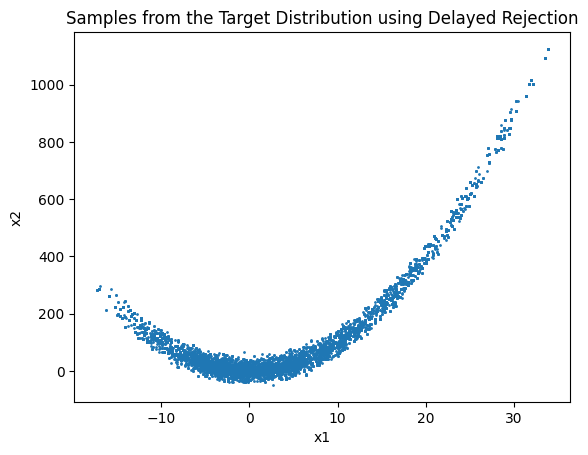

In [59]:
# Define the logpdf for the banana distribution
def target_logpdf(x):
    """Log probability density function of the banana distribution."""
    x1, x2 = x[0], x[1]

    # Log of the probability density
    log_pdf = -0.5 * (x1**2 + (x2 - (x1**2 + 1))**2)

    return log_pdf

# Initial sample and covariance matrix
# initial_sample = np.array([0, 0])  # Start at the center
# cov_matrix = np.array([[1, 0.9], [0.9, 1]])

# Initial sample and covariance matrix
initial_sample = map_estimate
cov_matrix = map_cov

# Create the Delayed Rejection Adaptive Metropolis sampler
gamma = 0.5  # Scale for the second level proposal
sampler = DelayedRejectionAdaptiveMetropolis(logpdf=target_logpdf, cov=cov_matrix, t0=100, freq=10, gamma=gamma)

# Generate samples from the target distribution
num_samples = 10000
samples = sampler.sample(initial_sample, num_samples)
samples_DRAM = samples[2000:]

# Plot the results
import matplotlib.pyplot as plt

plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.title("Samples from the Target Distribution using Delayed Rejection")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


# PLOTS FOR 1st PART

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

def marginals(samples):
# 1D marginal distributions
  plt.figure(figsize=(12, 5))

  # Marginal for x1
  plt.subplot(1, 2, 1)
  sns.histplot(samples[:, 0], bins=50, kde=True)
  plt.title("1D Marginal Distribution of x1")
  plt.xlabel("x1")

  # Marginal for x2
  plt.subplot(1, 2, 2)
  sns.histplot(samples[:, 1], bins=50, kde=True)
  plt.title("1D Marginal Distribution of x2")
  plt.xlabel("x2")

  plt.tight_layout()
  plt.show()

def autocorrelations(samples):
  # Autocorrelation for x1
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plot_acf(samples[:, 0], lags=50)
  plt.title("Autocorrelation of x1")

  # Autocorrelation for x2
  plt.subplot(1, 2, 2)
  plot_acf(samples[:, 1], lags=50)
  plt.title("Autocorrelation of x2")

  plt.tight_layout()
  plt.show()


# Trace plots for x1 and x2

def trace_plots(samples):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(samples[:, 0])
  plt.title("Trace plot for x1")
  plt.xlabel("Iteration")
  plt.ylabel("x1")

  plt.subplot(1, 2, 2)
  plt.plot(samples[:, 1])
  plt.title("Trace plot for x2")
  plt.xlabel("Iteration")
  plt.ylabel("x2")

  plt.tight_layout()
  plt.show()

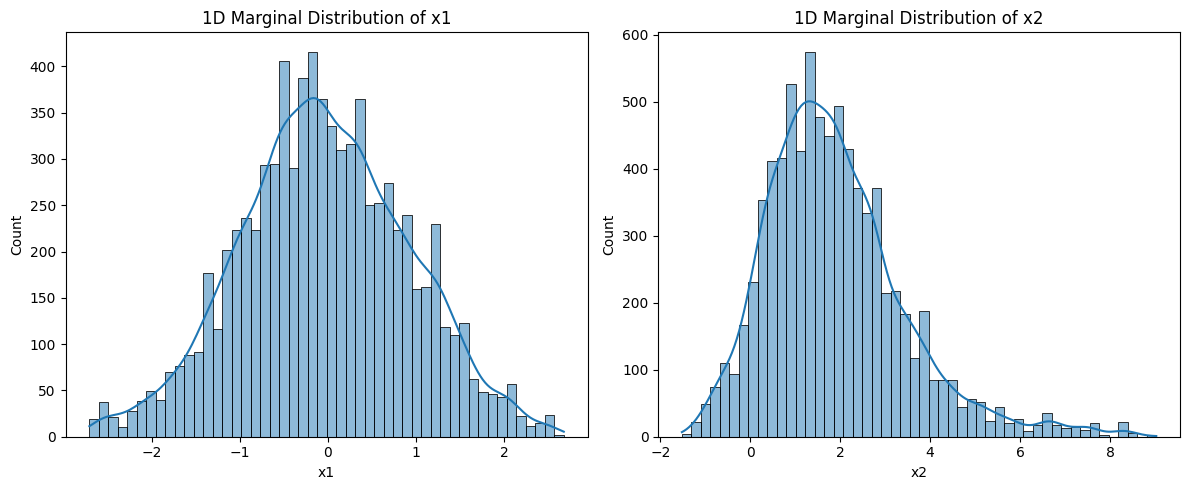

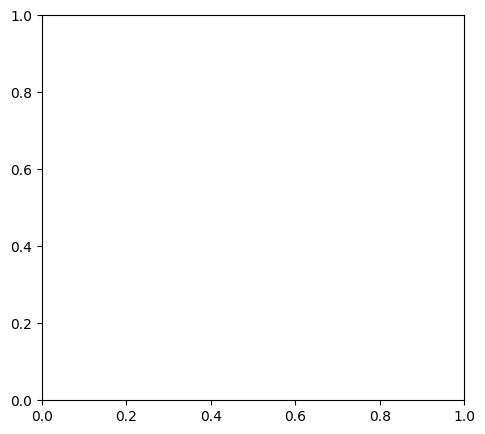

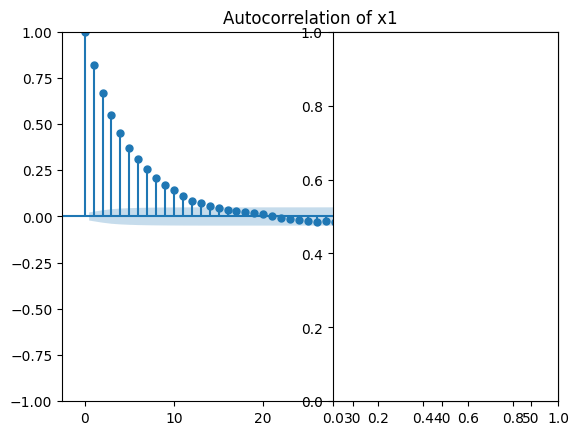

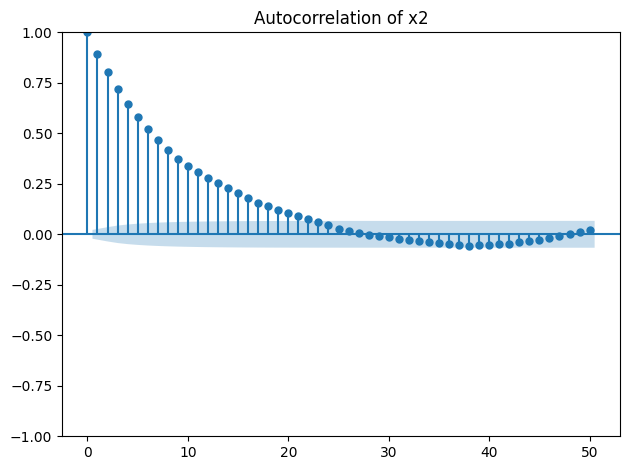

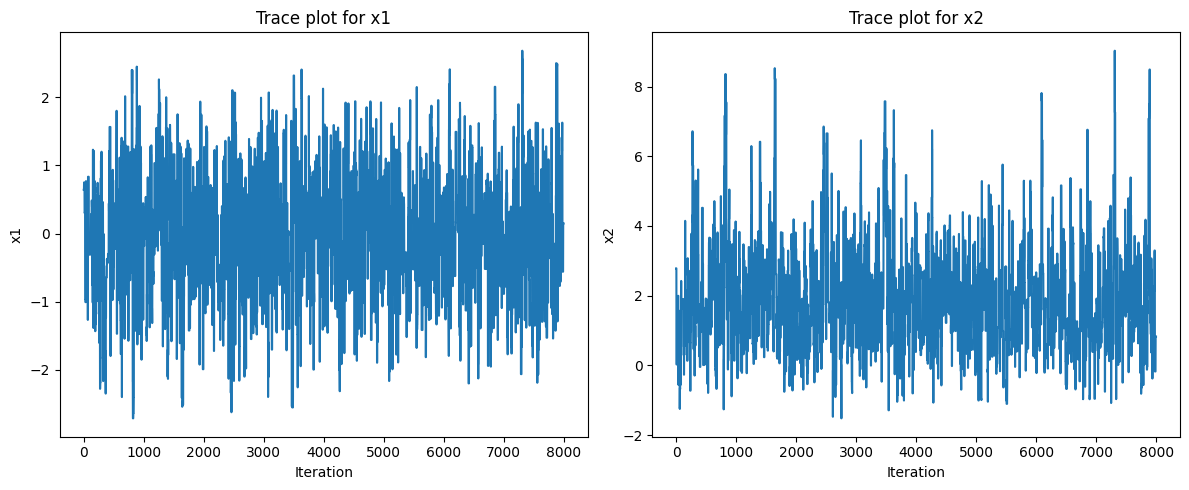

In [61]:
marginals(samples_MH)
autocorrelations(samples_MH)
trace_plots(samples_MH)

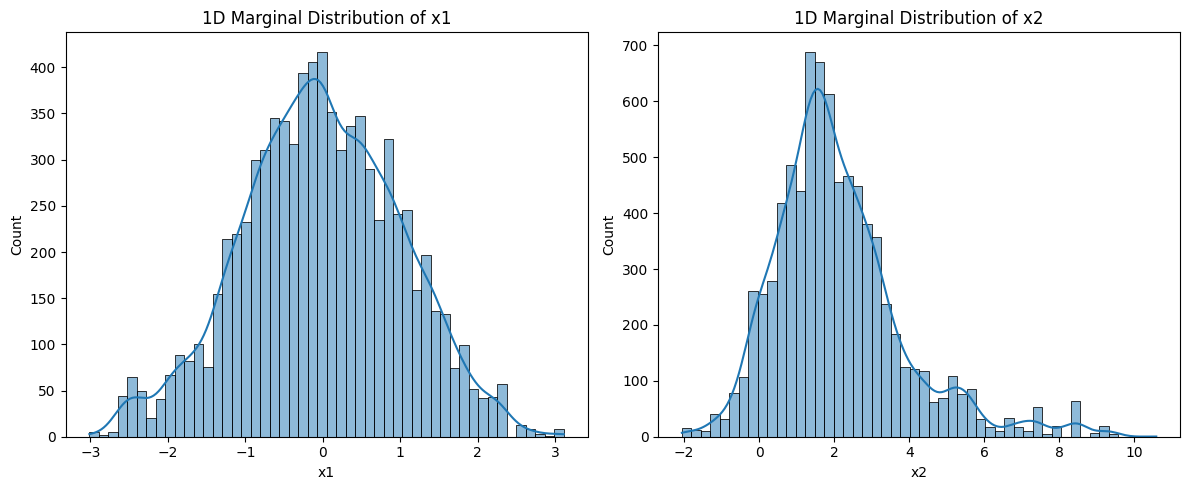

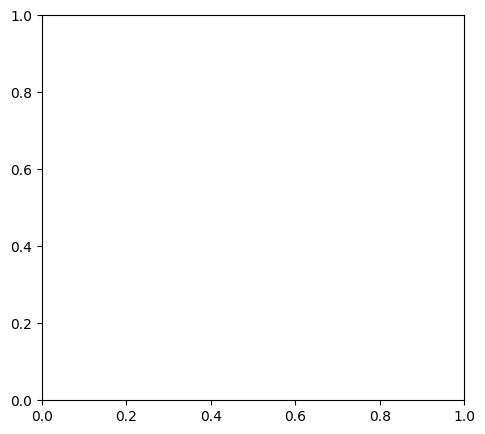

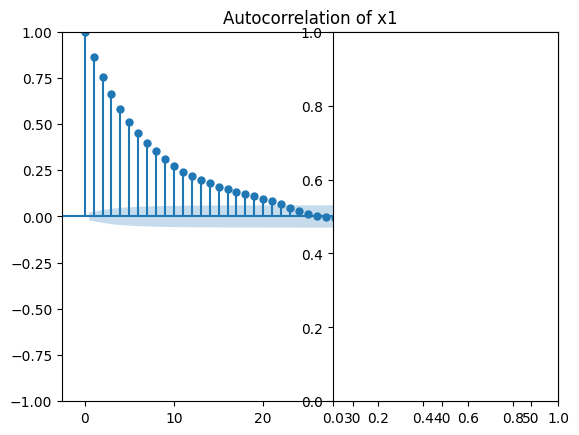

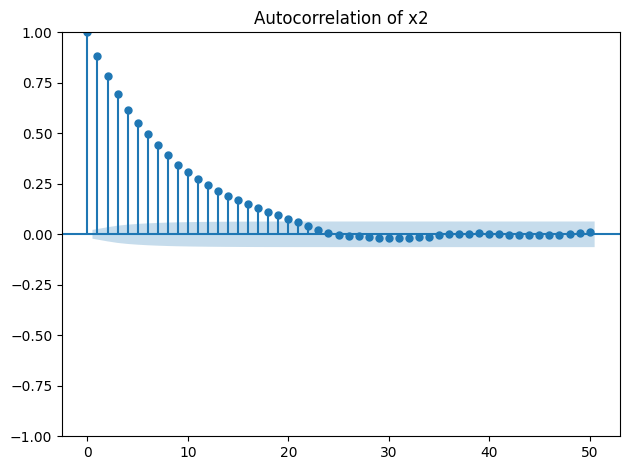

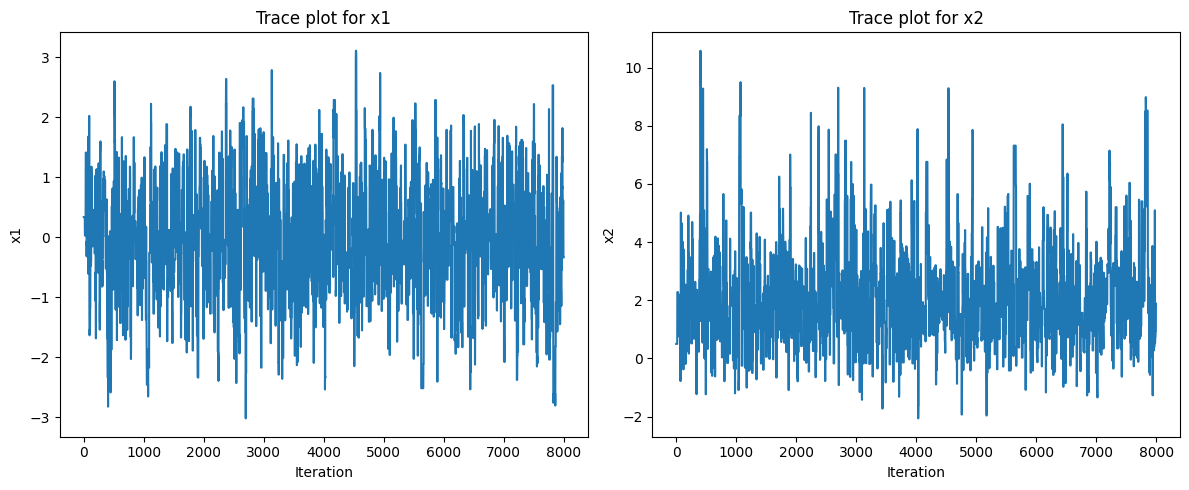

In [62]:
marginals(samples_AM)
autocorrelations(samples_AM)
trace_plots(samples_AM)

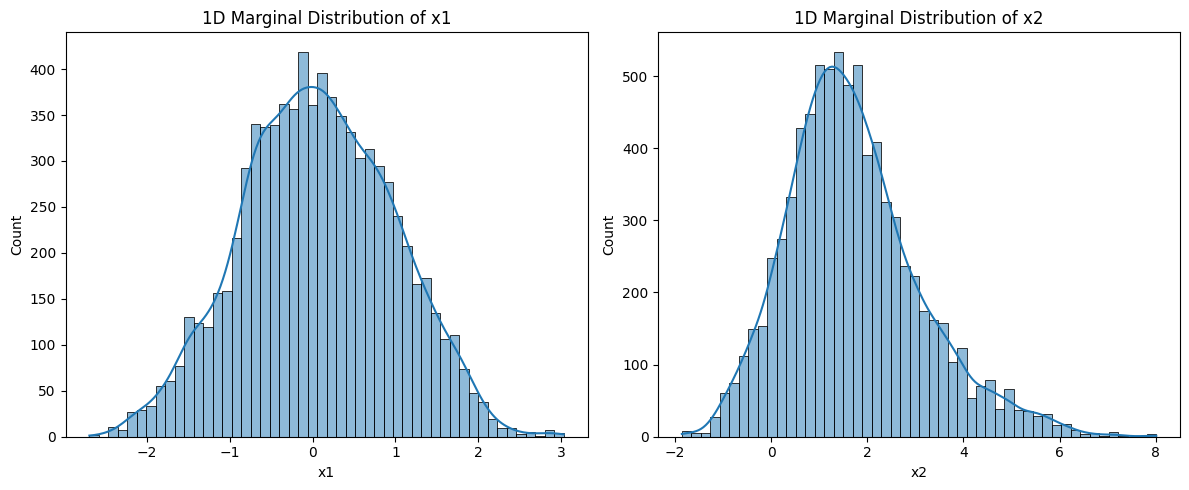

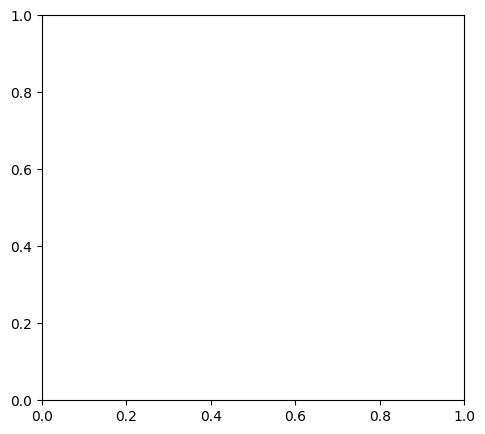

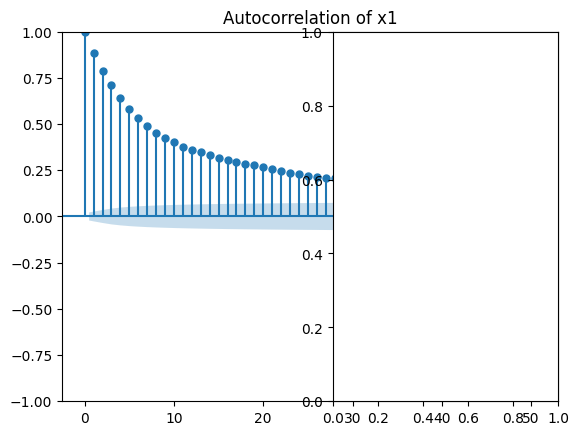

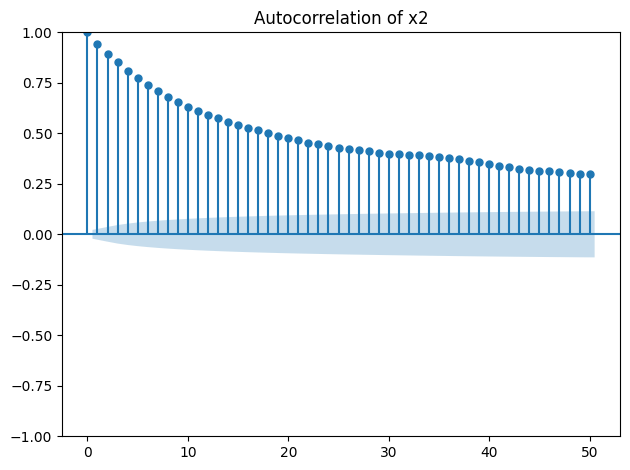

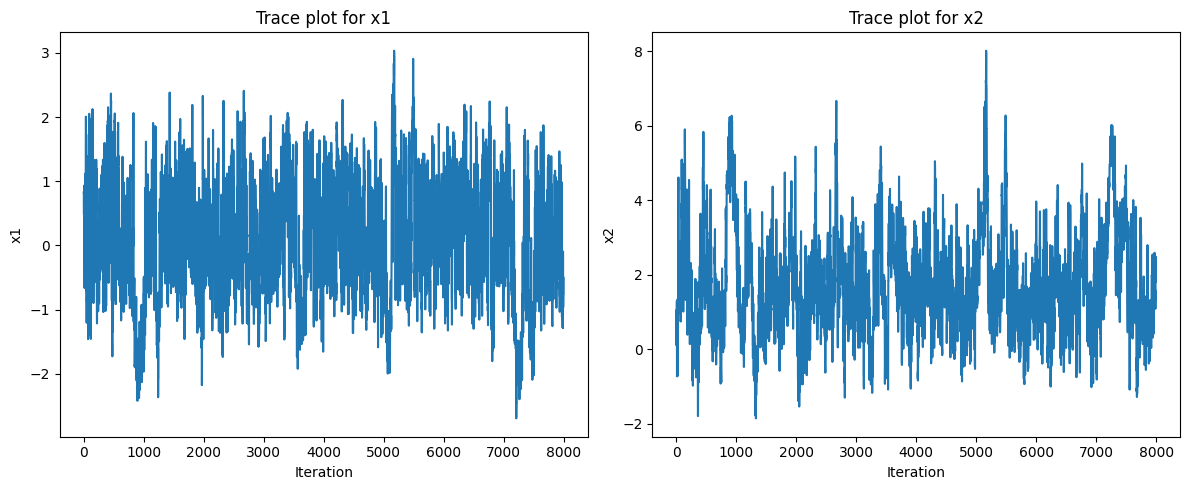

In [63]:
marginals(samples_DR)
autocorrelations(samples_DR)
trace_plots(samples_DR)

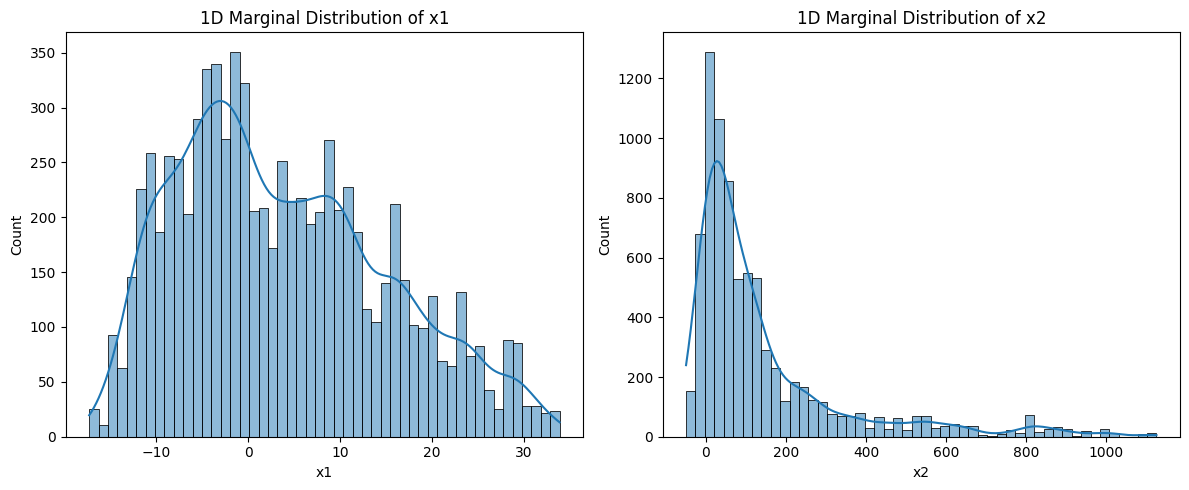

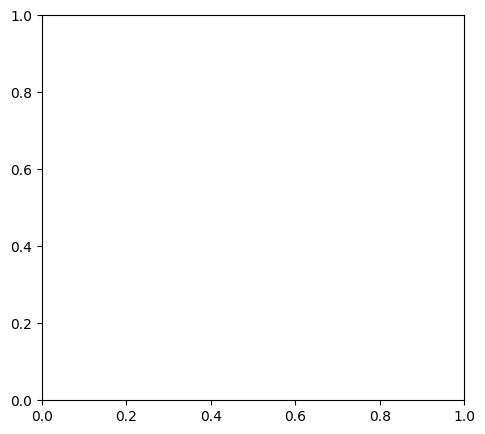

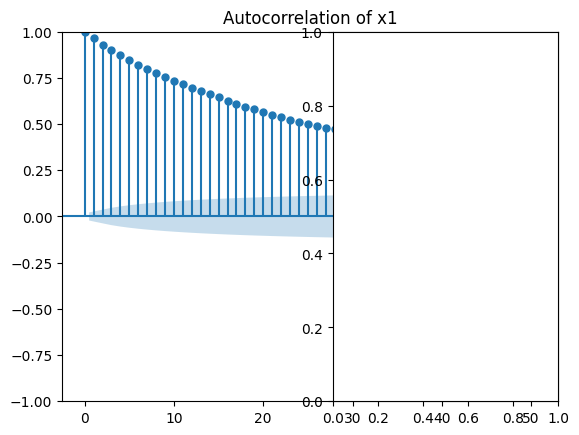

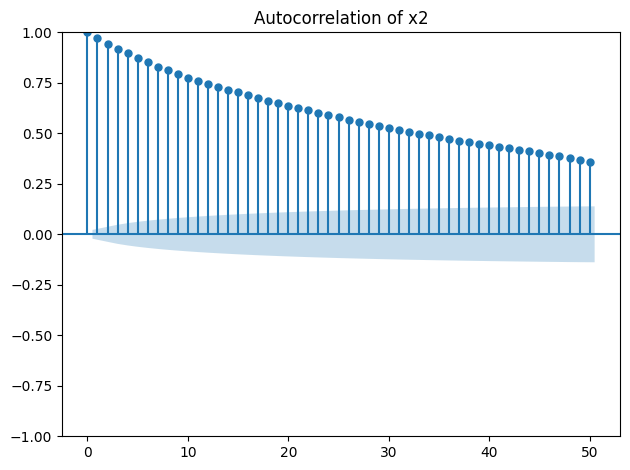

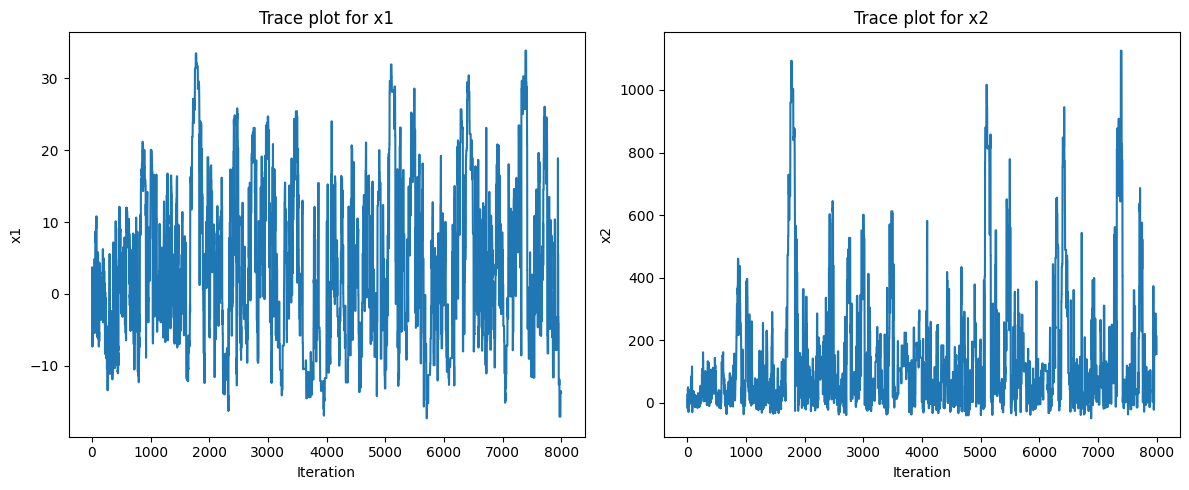

In [64]:
marginals(samples_DRAM)
autocorrelations(samples_DRAM)
trace_plots(samples_DRAM)

In [66]:
from re import A
from statsmodels.tsa.stattools import acf
def integrated_autocorrelation(samples):
    autocorr = acf(samples, nlags=50, fft=True)
    iac = 1 + 2 * np.sum(autocorr[1:])
    print(f"Integrated autocorrelation time for x1: {iac:.2f}")

print("MH")
integrated_autocorrelation(samples_MH[:, 0])
integrated_autocorrelation(samples_MH[:, 1])
print(" ")
print("AM")
integrated_autocorrelation(samples_AM[:, 0])
integrated_autocorrelation(samples_AM[:, 1])
print(" ")
print("DR")
integrated_autocorrelation(samples_DR[:, 0])
integrated_autocorrelation(samples_DR[:, 1])
print(" ")
print("DRAM")
integrated_autocorrelation(samples_DRAM[:, 0])
integrated_autocorrelation(samples_DRAM[:, 1])


MH
Integrated autocorrelation time for x1: 8.92
Integrated autocorrelation time for x1: 15.82
 
AM
Integrated autocorrelation time for x1: 13.32
Integrated autocorrelation time for x1: 15.35
 
DR
Integrated autocorrelation time for x1: 30.21
Integrated autocorrelation time for x1: 49.53
 
DRAM
Integrated autocorrelation time for x1: 55.90
Integrated autocorrelation time for x1: 61.26


# SIR Model

MAP Estimate of Parameters: [0.62264687 0.54024169 0.09827154]
Approximate Covariance Matrix from Laplace Approximation: {} [[ 0.91004    -0.07191711 -0.14412875]
 [-0.07191711  0.00690011  0.01226525]
 [-0.14412875  0.01226525  0.0240069 ]]


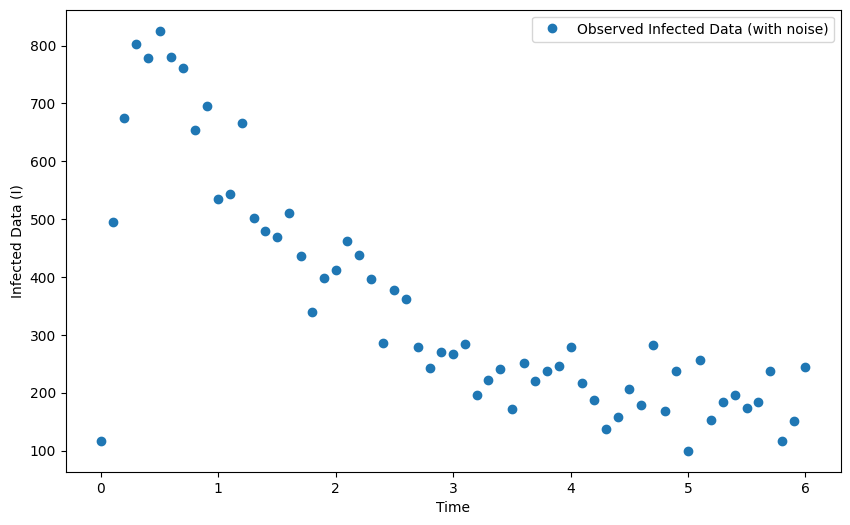

In [ ]:
### IDENTIFIABLE CASE ###
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def sir_model(t, y, beta, r, delta):
  S,I,R = y
  N = 1000 # Population fixed
  dS_dt = delta*N-delta*S-beta*S*I
  dI_dt = beta*S*I - (r+delta)*I
  dR_dt = r*I-delta*R
  return [dS_dt,dI_dt,dR_dt]

def generate_sir(beta, r, delta, num_samples=61, t_span=(0,6)):
  S0, I0, R0 = 900, 100, 0
  y0 = [S0, I0, R0]
  t_eval = np.linspace(t_span[0], t_span[1], num_samples)
  sol = solve_ivp(sir_model, t_span,y0, t_eval=t_eval, args=(beta, r, delta))
  I_true = sol.y[1]
  I_noisy = sol.y[1] + np.random.normal(0, 50, size=sol.y[1].shape)
  return sol.t, I_noisy

# Define the likelihood function
def calculate_likelihood(params, t_data, I_data, noise_std):
    beta, r, delta = params
    S0, I0, R0 = 900, 100, 0
    y0 = [S0, I0, R0]

    # Solve the ODE for the current parameter set
    sol = solve_ivp(sir_model, (t_data[0], t_data[-1]), y0, args=(beta, r, delta), t_eval=t_data)
    I_model = sol.y[1]

    # Gaussian likelihood
    error = I_data - I_model
    likelihood = -0.5 * np.sum((error / noise_std) ** 2)
    return likelihood

# Define Gaussian prior for each parameter with standard normal distribution
def calculate_prior(params):
    beta, r, delta = params

    # Standard normal prior parameters (mean = 0, std = 1) for each parameter
    beta_mean, beta_std = 0, 1
    r_mean, r_std = 0, 1
    delta_mean, delta_std = 0, 1

    # Gaussian log-priors for each parameter
    log_prior_beta = -0.5 * ((beta - beta_mean) / beta_std) ** 2 - np.log(beta_std * np.sqrt(2 * np.pi))
    log_prior_r = -0.5 * ((r - r_mean) / r_std) ** 2 - np.log(r_std * np.sqrt(2 * np.pi))
    log_prior_delta = -0.5 * ((delta - delta_mean) / delta_std) ** 2 - np.log(delta_std * np.sqrt(2 * np.pi))

    # Sum the log-priors (logarithm of product of independent priors)
    return log_prior_beta + log_prior_r + log_prior_delta

def calculate_posterior(params, t_data, I_data, noise_std):
    prior = calculate_prior(params)
    if np.isinf(prior):
        return -np.inf  # If prior is zero, posterior is zero
    likelihood = calculate_likelihood(params, t_data, I_data, noise_std)
    return prior + likelihood  # log posterior

# Define the negative log-posterior for optimization
def negative_log_posterior(params):
    return -calculate_posterior(params, t_data, I_data, noise_std=50)

# Generate synthetic data to use as "observed data"
true_params = (0.02, 0.6, 0.15)
t_data, I_data = generate_sir(*true_params)


### LAPLACE APPROX START ###
# Step 1: Find the MAP estimate using optimization
initial_guess = np.random.rand(3)
result = minimize(negative_log_posterior, initial_guess, method='L-BFGS-B', bounds=[(0, 1), (0, 1), (0, 1)])
map_estimate = result.x  # This is the MAP estimate of [beta, r, delta]
print("MAP Estimate of Parameters:", map_estimate)

# Approximate Covariance Matrix (Inverse Hessian from the result)
if result.success and 'hess_inv' in result:
    covariance_matrix = result.hess_inv.todense()  # Directly from the optimization result
    print("Approximate Covariance Matrix from Laplace Approximation: {}", covariance_matrix)
else:
    print("Failed to estimate covariance matrix.")

### LAPLACE APPROX END ###

# Plot the synthetic data
plt.figure(figsize=(10, 6))
plt.plot(t_data, I_data, 'o', label="Observed Infected Data (with noise)")
plt.xlabel("Time")
plt.ylabel("Infected Data (I)")
plt.legend()
plt.show()

<ipython-input-6-ac5ba4d2f758>:42: RuntimeWarning: overflow encountered in exp
  rejection_prob = np.exp(y2_logpdf - y1_logpdf)


Finished sample 1000, acceptance ratio = 0.82
Finished sample 2000, acceptance ratio = 0.808
Finished sample 3000, acceptance ratio = 0.7936666666666666
Finished sample 4000, acceptance ratio = 0.786
Finished sample 5000, acceptance ratio = 0.7804
Finished sample 6000, acceptance ratio = 0.7756666666666666
Finished sample 7000, acceptance ratio = 0.7741428571428571
Finished sample 8000, acceptance ratio = 0.771875
Finished sample 9000, acceptance ratio = 0.7684444444444445
Finished sample 10000, acceptance ratio = 0.7649


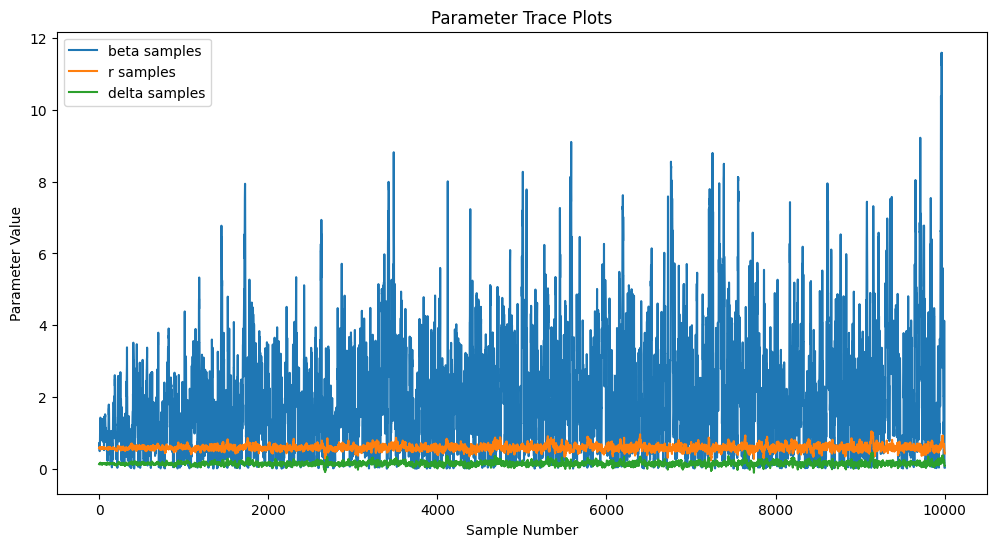

In [ ]:
# Set up the MCMC parameters
num_samples = 10001  # Total number of MCMC samples
initial_params = map_estimate # Initial guess for parameters (beta, r, delta) using MAP
# step_size = [0.1, 0.5, 0.1]  # Step size for proposal distribution
# initial_cov = np.diag(np.square(step_size))
initial_cov = covariance_matrix
noise_std = 50  # Standard deviation of the noise in synthetic data

# Generate synthetic observed data for the identifiable version of the SIR model
true_params = (0.02, 0.6, 0.15)
t_data, I_data = generate_sir(*true_params)

# Define the log-posterior function (combines prior and likelihood)
def log_posterior(params):
    return calculate_posterior(params, t_data, I_data, noise_std)


# Initialize the Adaptive Metropolis sampler
sampler = DelayedRejectionAdaptiveMetropolis(logpdf=log_posterior, cov=initial_cov, max_samples=num_samples)

# Run the MCMC sampling
samples = sampler.sample(initial_sample=initial_params, num_samples=num_samples)

# Plot the results
plt.figure(figsize=(12, 6))
for i, param_name in enumerate(["beta", "r", "delta"]):
    plt.plot(samples[:, i], label=f"{param_name} samples")
plt.xlabel("Sample Number")
plt.ylabel("Parameter Value")
plt.legend()
plt.title("Parameter Trace Plots")
plt.show()


In [ ]:
import numpy as np

burn_in = 2000
samples = samples[burn_in:]

# `samples` is an array of shape (num_samples, 3) containing samples of [beta, r, delta]
beta_samples = samples[:, 0]
r_samples = samples[:, 1]
delta_samples = samples[:, 2]

# Mean estimates
beta_mean = np.mean(beta_samples)
r_mean = np.mean(r_samples)
delta_mean = np.mean(delta_samples)

# Median estimates
beta_median = np.median(beta_samples)
r_median = np.median(r_samples)
delta_median = np.median(delta_samples)

# 95% credible intervals
beta_cred_int = np.percentile(beta_samples, [2.5, 97.5])
r_cred_int = np.percentile(r_samples, [2.5, 97.5])
delta_cred_int = np.percentile(delta_samples, [2.5, 97.5])

print(f"Beta: mean = {beta_mean}, median = {beta_median}, 95% CI = {beta_cred_int}")
print(f"R: mean = {r_mean}, median = {r_median}, 95% CI = {r_cred_int}")
print(f"Delta: mean = {delta_mean}, median = {delta_median}, 95% CI = {delta_cred_int}")


Beta: mean = 2.0885576721997747, median = 1.7581031206786717, 95% CI = [0.03471059 6.20555433]
R: mean = 0.5971203328784821, median = 0.5928710988798198, 95% CI = [0.43617524 0.79169272]
Delta: mean = 0.15363193011786636, median = 0.15138263850507688, 95% CI = [0.04738523 0.27528345]


# PLOTS

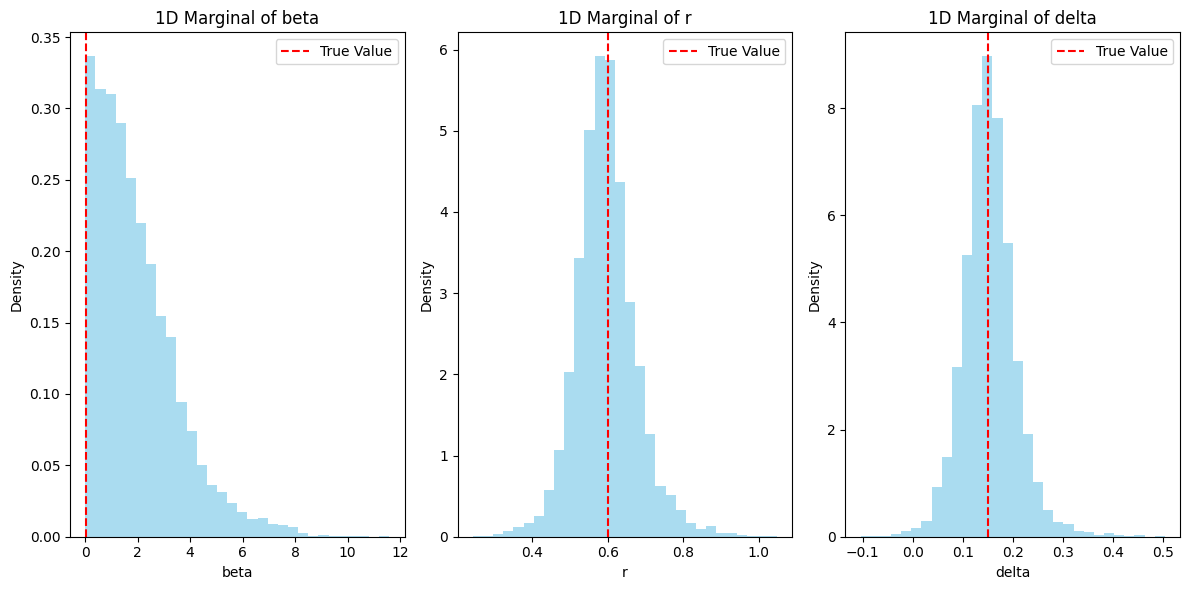

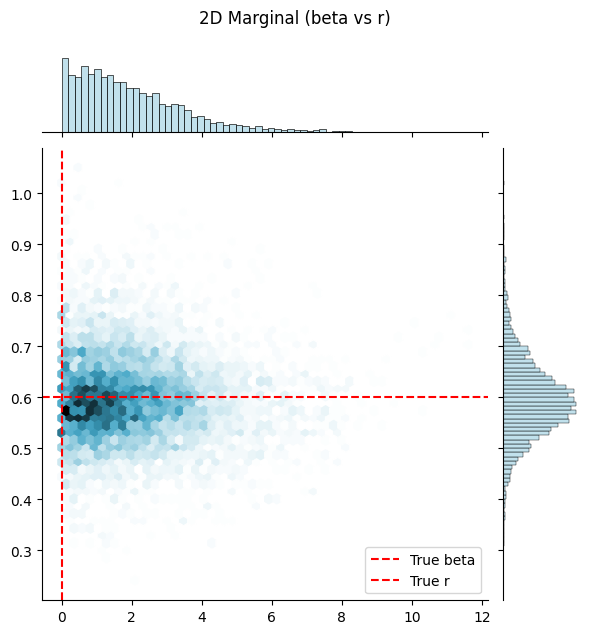

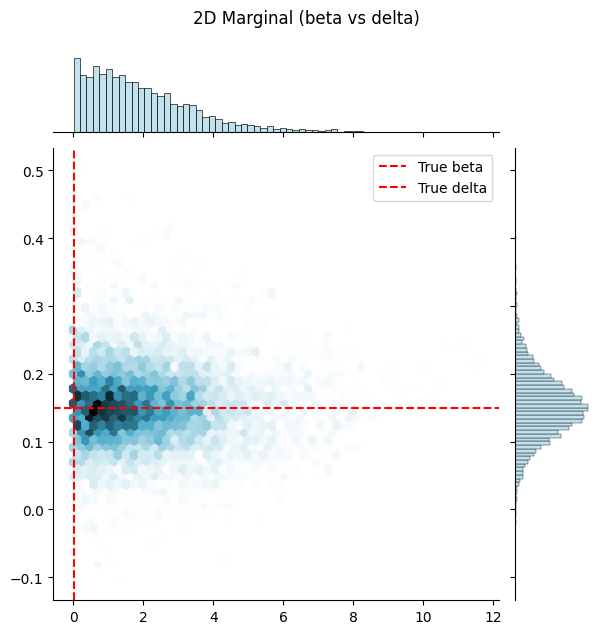

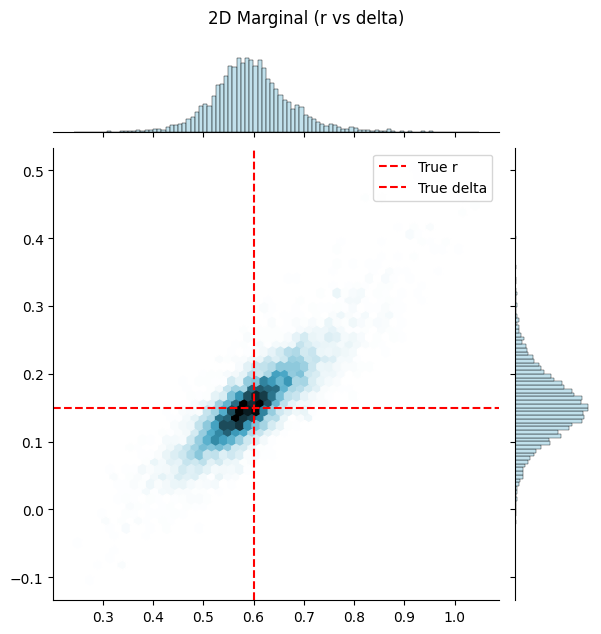

In [ ]:
# True parameters for reference
true_params = [0.02, 0.6, 0.15]

# 1D Marginals with true parameters overlayed
plt.figure(figsize=(12, 6))
for i, (param_name, true_val) in enumerate(zip(["beta", "r", "delta"], true_params)):
    plt.subplot(1, 3, i + 1)
    plt.hist(samples[:, i], bins=30, density=True, alpha=0.7, color="skyblue")
    plt.axvline(true_val, color="red", linestyle="--", label="True Value")
    plt.title(f"1D Marginal of {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Density")
    plt.legend()
plt.tight_layout()
plt.show()

# 2D Marginals with true parameters overlayed
import seaborn as sns

for (i, j), (param1, param2) in zip([(0, 1), (0, 2), (1, 2)], [("beta", "r"), ("beta", "delta"), ("r", "delta")]):
    sns.jointplot(x=samples[:, i], y=samples[:, j], kind="hex", color="lightblue")
    plt.axvline(true_params[i], color="red", linestyle="--", label=f"True {param1}")
    plt.axhline(true_params[j], color="red", linestyle="--", label=f"True {param2}")
    plt.suptitle(f'2D Marginal ({param1} vs {param2})', y=1.05)
    plt.legend()
    plt.show()


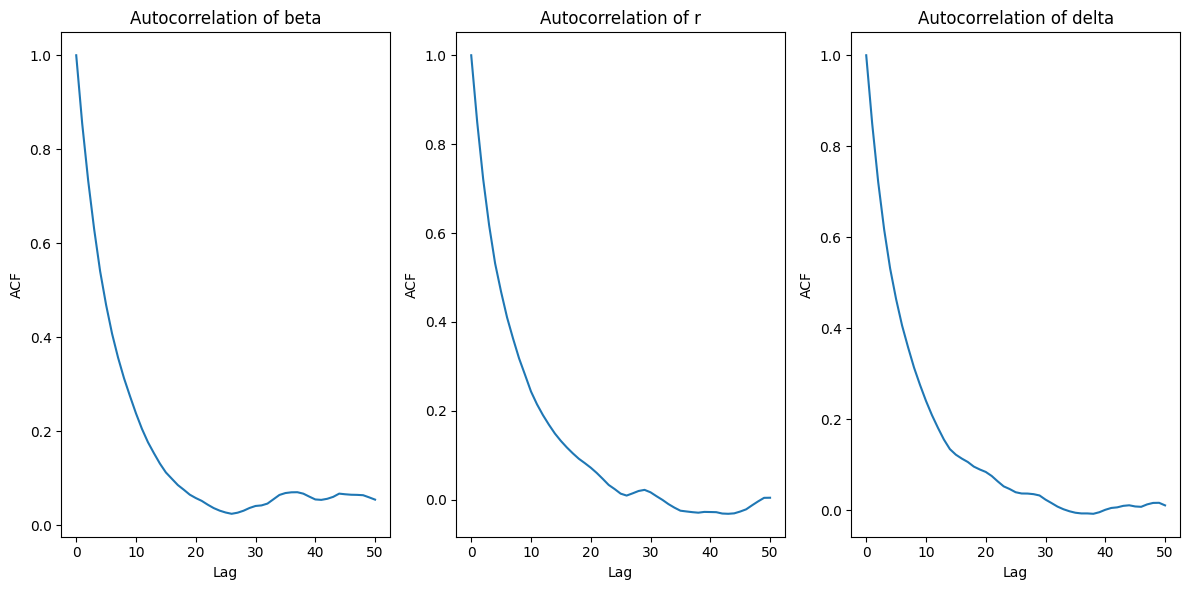

In [ ]:
from statsmodels.tsa.stattools import acf

# Plot autocorrelation for each parameter
plt.figure(figsize=(12, 6))
for i, param_name in enumerate(["beta", "r", "delta"]):
    plt.subplot(1, 3, i + 1)
    acf_vals = acf(samples[:, i], nlags=50)
    plt.plot(acf_vals)
    plt.title(f"Autocorrelation of {param_name}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Integrated Autocorrelation for each parameter
from statsmodels.tsa.stattools import acf

def integrated_autocorrelation(chain):
    acf_vals = acf(chain, nlags=len(chain) // 2, fft=True)
    return np.sum(2 * acf_vals[1:]) - 1  # Approximate IAC using ACF

iac_values = [integrated_autocorrelation(samples[:, i]) for i in range(3)]
for i, param_name in enumerate(["beta", "r", "delta"]):
    print(f"Integrated Autocorrelation for {param_name}: {iac_values[i]}")


Integrated Autocorrelation for beta: 111.30746733454775
Integrated Autocorrelation for r: 7.098820972428811
Integrated Autocorrelation for delta: 2.1346907533841035


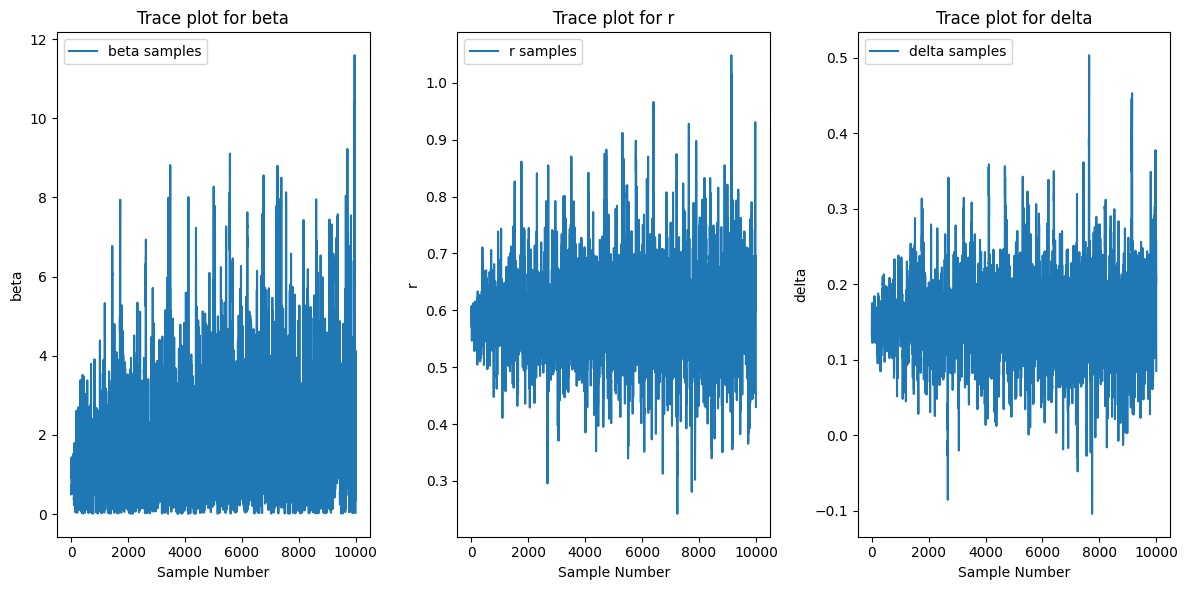

In [ ]:
# Plotting the trace plots for all parameters
plt.figure(figsize=(12, 6))
for i, param_name in enumerate(["beta", "r", "delta"]):
    plt.subplot(1, 3, i + 1)
    plt.plot(samples[:, i], label=f"{param_name} samples")
    plt.title(f"Trace plot for {param_name}")
    plt.xlabel("Sample Number")
    plt.ylabel(f"{param_name}")
    plt.legend()
plt.tight_layout()
plt.show()


## PRIOR PREDICTIVE PLOT

In [ ]:
# Sample from the prior and generate dynamics
prior_samples = np.random.normal(0, 1, size=(2, 3))  # 61 samples from the prior (mean 0, std 1)

# Plot prior predictions over the "true" dynamics
plt.figure(figsize=(10, 6))
for beta, r, delta in prior_samples:
    t_prior, I_prior = generate_sir(beta, r, delta)
    plt.plot(t_prior, I_prior, color="gray", alpha=0.3)

# Plot true dynamics
t_true, I_true = generate_sir(*true_params)
plt.plot(t_true, I_true, 'r-', label="True Dynamics")
plt.scatter(t_data, I_data, color="blue", label="Observed Data", s=20)
plt.xlabel("Time")
plt.ylabel("Infected Population (I)")
plt.legend()
plt.title("Prior Prediction")
plt.show()


NameError: name 'np' is not defined

## POSTERIOR PREDICTIVE PLOT

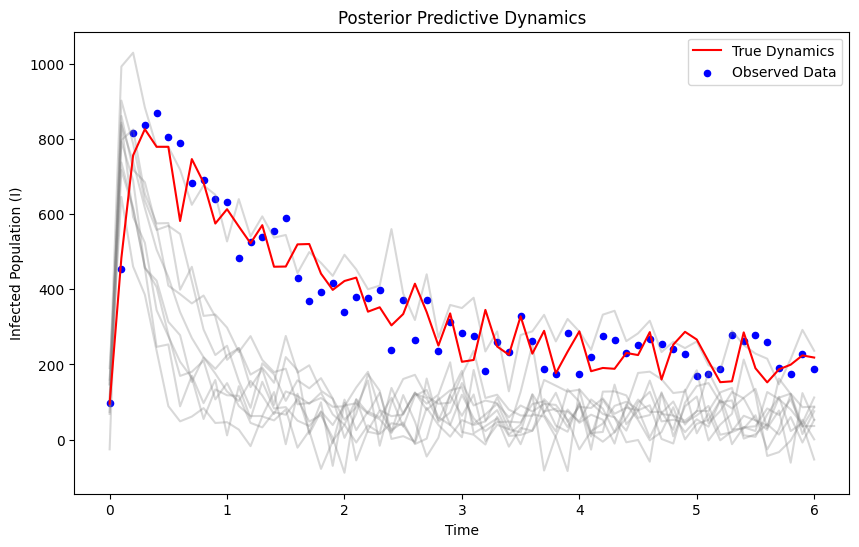

In [ ]:
# Sample some points from the posterior
posterior_samples = samples[np.random.choice(len(samples), size=10, replace=False)]  # Select 61 posterior samples

# Plot posterior predictions over the "true" dynamics
plt.figure(figsize=(10, 6))
for beta, r, delta in posterior_samples:
    t_post, I_post = generate_sir(beta, beta, delta)
    plt.plot(t_post, I_post, color="gray", alpha=0.3)

# Plot true dynamics
plt.plot(t_true, I_true, 'r-', label="True Dynamics")
plt.scatter(t_data, I_data, color="blue", label="Observed Data", s=20)
plt.xlabel("Time")
plt.ylabel("Infected Population (I)")
plt.legend()
plt.title("Posterior Predictive Dynamics")
plt.show()


# NON-IDENTIFIABLE CASE

MAP Estimate of Parameters: [0.6406545  0.64362305 0.53051008 0.10119616]
Approximate Covariance Matrix from Laplace Approximation: {} [[ 21.9938918  -27.26294384  -0.73253709  -0.82663483]
 [-27.26294384  34.49910689   1.02437211   1.15664106]
 [ -0.73253709   1.02437211   0.04413008   0.04965107]
 [ -0.82663483   1.15664106   0.04965107   0.05609666]]


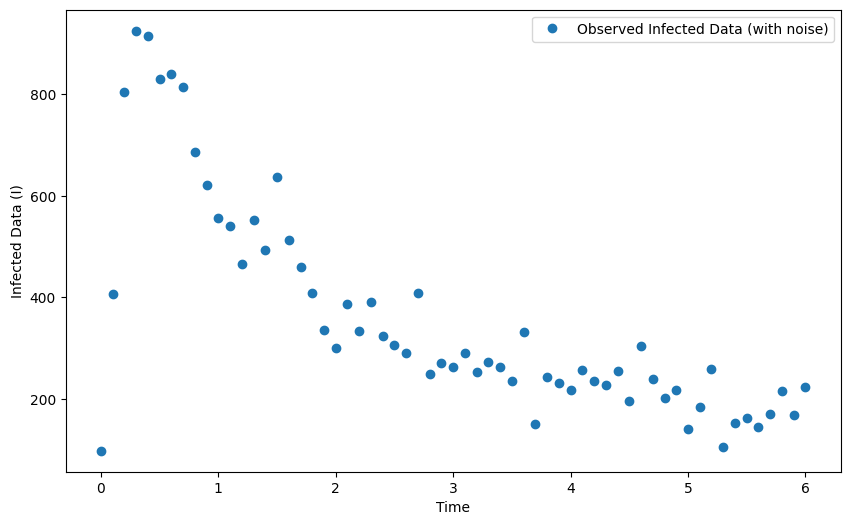

In [ ]:
### NON-IDENTIFIABLE CASE ###
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def sir_model(t, y, gamma, kappa, r, delta):
  S,I,R = y
  N = 1000 # Population fixed
  dS_dt = delta*N-delta*S-gamma*kappa*S*I
  dI_dt = gamma*kappa*S*I - (r+delta)*I
  dR_dt = r*I-delta*R
  return [dS_dt,dI_dt,dR_dt]

def generate_sir(gamma, kappa, r, delta, num_samples=61, t_span=(0,6)):
  S0, I0, R0 = 900, 100, 0
  y0 = [S0, I0, R0]
  t_eval = np.linspace(t_span[0], t_span[1], num_samples)
  sol = solve_ivp(sir_model, t_span,y0, t_eval=t_eval, args=(gamma, kappa, r, delta))
  I_true = sol.y[1]
  I_noisy = sol.y[1] + np.random.normal(0, 50, size=sol.y[1].shape)
  return sol.t, I_noisy

# Define the likelihood function
def calculate_likelihood(params, t_data, I_data, noise_std):
    gamma, kappa, r, delta = params
    S0, I0, R0 = 900, 100, 0
    y0 = [S0, I0, R0]

    # Solve the ODE for the current parameter set
    sol = solve_ivp(sir_model, (t_data[0], t_data[-1]), y0, args=(gamma, kappa, r, delta), t_eval=t_data)
    I_model = sol.y[1]

    # Gaussian likelihood
    error = I_data - I_model
    likelihood = -0.5 * np.sum((error / noise_std) ** 2)
    return likelihood

# Define Gaussian prior for each parameter with standard normal distribution
def calculate_prior(params):
    gamma, kappa, r, delta = params

    # Standard normal prior parameters (mean = 0, std = 1) for each parameter
    gamma_mean, gamma_std = 0, 1
    kappa_mean, kappa_std = 0, 1
    r_mean, r_std = 0, 1
    delta_mean, delta_std = 0, 1

    # Gaussian log-priors for each parameter
    log_prior_gamma = -0.5 * ((gamma - gamma_mean) / gamma_std) ** 2 - np.log(gamma_std * np.sqrt(2 * np.pi))
    log_prior_kappa = -0.5 * ((kappa - kappa_mean) / kappa_std) ** 2 - np.log(kappa_std * np.sqrt(2 * np.pi))
    log_prior_r =     -0.5 * ((r - r_mean) / r_std) ** 2 - np.log(r_std * np.sqrt(2 * np.pi))
    log_prior_delta = -0.5 * ((delta - delta_mean) / delta_std) ** 2 - np.log(delta_std * np.sqrt(2 * np.pi))

    # Sum the log-priors (logarithm of product of independent priors)
    return log_prior_gamma + log_prior_kappa + log_prior_r + log_prior_delta

def calculate_posterior(params, t_data, I_data, noise_std):
    prior = calculate_prior(params)
    if np.isinf(prior):
        return -np.inf  # If prior is zero, posterior is zero
    likelihood = calculate_likelihood(params, t_data, I_data, noise_std)
    return prior + likelihood  # log posterior

# Define the negative log-posterior for optimization
def negative_log_posterior(params):
    return -calculate_posterior(params, t_data, I_data, noise_std=50)

# Generate synthetic data to use as "observed data"
true_params = (0.1, 0.2, 0.6, 0.15)
t_data, I_data = generate_sir(*true_params)


### LAPLACE APPROX START ###
# Step 1: Find the MAP estimate using optimization
initial_guess = np.random.rand(4)
result = minimize(negative_log_posterior, initial_guess, method='L-BFGS-B', bounds=[(0, 1), (0, 1), (0, 1), (0,1)])
map_estimate = result.x  # This is the MAP estimate of [beta, r, delta]
print("MAP Estimate of Parameters:", map_estimate)

# Approximate Covariance Matrix (Inverse Hessian from the result)
if result.success and 'hess_inv' in result:
    covariance_matrix = result.hess_inv.todense()  # Directly from the optimization result
    print("Approximate Covariance Matrix from Laplace Approximation: {}", covariance_matrix)
else:
    print("Failed to estimate covariance matrix.")

### LAPLACE APPROX END ###

# Plot the synthetic data
plt.figure(figsize=(10, 6))
plt.plot(t_data, I_data, 'o', label="Observed Infected Data (with noise)")
plt.xlabel("Time")
plt.ylabel("Infected Data (I)")
plt.legend()
plt.show()

In [ ]:
# Set up the MCMC parameters
num_samples = 10001  # Total number of MCMC samples
initial_params = map_estimate # Initial guess for parameters (beta, r, delta) using MAP
initial_cov = covariance_matrix
noise_std = 50  # Standard deviation of the noise

# Generating synthetic observed data for the identifiable version of the SIR model
true_params = (0.1, 0.2, 0.6, 0.15)
t_data, I_data = generate_sir(*true_params)

# Defining the log-posterior function (combines prior and likelihood)
def log_posterior(params):
    return calculate_posterior(params, t_data, I_data, noise_std)


sampler = DelayedRejectionAdaptiveMetropolis(logpdf=log_posterior, cov=initial_cov, max_samples=num_samples)

# Running the MCMC sampling
samples = sampler.sample(initial_sample=initial_params, num_samples=num_samples)

# Plotting the results
plt.figure(figsize=(12, 6))
for i, param_name in enumerate(["gamma", "kappa", "r", "delta"]):
    plt.plot(samples[:, i], label=f"{param_name} samples")
plt.xlabel("Sample Number")
plt.ylabel("Parameter Value")
plt.legend()
plt.title("Parameter Trace Plots")
plt.show()


<ipython-input-6-ac5ba4d2f758>:42: RuntimeWarning: overflow encountered in exp
  rejection_prob = np.exp(y2_logpdf - y1_logpdf)


In [ ]:
import numpy as np

#burn_in = 2000
#samples = samples[burn_in:]

# `samples` is an array of shape (num_samples, 4) containing samples of [gamma, kappa, r, delta]
gamma_samples = samples[:, 0]
kappa_samples = samples[:, 1]
r_samples = samples[:, 2]
delta_samples = samples[:, 3]

# Mean estimates
gamma_mean = np.mean(gamma_samples)
kappa_mean = np.mean(kappa_samples)
r_mean = np.mean(r_samples)
delta_mean = np.mean(delta_samples)

# Median estimates
gamma_median = np.median(gamma_samples)
kappa_median = np.median(kappa_samples)
r_median = np.median(r_samples)
delta_median = np.median(delta_samples)

# 95% credible intervals
gamma_cred_int = np.percentile(gamma_samples, [2.5, 97.5])
kappa_cred_int = np.percentile(kappa_samples, [2.5, 97.5])
r_cred_int = np.percentile(r_samples, [2.5, 97.5])
delta_cred_int = np.percentile(delta_samples, [2.5, 97.5])

print(f"Gamma: mean = {gamma_mean}, median = {gamma_median}, 95% CI = {gamma_cred_int}")
print(f"Kappa: mean = {kappa_mean}, median = {kappa_median}, 95% CI = {kappa_cred_int}")
print(f"R: mean = {r_mean}, median = {r_median}, 95% CI = {r_cred_int}")
print(f"Delta: mean = {delta_mean}, median = {delta_median}, 95% CI = {delta_cred_int}")


# PLOTS NON-IDENTIFIABLE CASE

In [ ]:
# True parameters for reference
true_params = [0.1, 0.2, 0.6, 0.15]

# 1D Marginals with true parameters overlayed
plt.figure(figsize=(12, 6))
for i, (param_name, true_val) in enumerate(zip(["gamma", "kappa", "r", "delta"], true_params)):
    plt.subplot(1, 4, i + 1)
    plt.hist(samples[:, i], bins=30, density=True, alpha=0.7, color="skyblue")
    plt.axvline(true_val, color="red", linestyle="--", label="True Value")
    plt.title(f"1D Marginal of {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Density")
    plt.legend()
plt.tight_layout()
plt.show()

# 2D Marginals with true parameters overlayed
import seaborn as sns

param_list = [("gamma", "kappa"), ("gamma", "r"), ("kappa", "r"), ("gamma", "delta"), ("kappa","delta"), ("r", "delta")]
for (i, j), (param1, param2) in zip([(0, 1), (0, 2), (1, 2), (0, 3), (1, 3),(2, 3)], param_list):
    sns.jointplot(x=samples[:, i], y=samples[:, j], kind="hex", color="lightblue")
    plt.axvline(true_params[i], color="red", linestyle="--", label=f"True {param1}")
    plt.axhline(true_params[j], color="red", linestyle="--", label=f"True {param2}")
    plt.suptitle(f'2D Marginal ({param1} vs {param2})', y=1.05)
    plt.legend()
    plt.show()


In [ ]:
from statsmodels.tsa.stattools import acf

# Plot autocorrelation for each parameter
plt.figure(figsize=(12, 6))
for i, param_name in enumerate(["gamma", "kappa", "r", "delta"]):
    plt.subplot(1, 4, i + 1)
    acf_vals = acf(samples[:, i], nlags=50)
    plt.plot(acf_vals)
    plt.title(f"Autocorrelation of {param_name}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Integrated Autocorrelation for each parameter
from statsmodels.tsa.stattools import acf

def integrated_autocorrelation(chain):
    acf_vals = acf(chain, nlags=len(chain) // 2, fft=True)
    return np.sum(2 * acf_vals[1:]) - 1

iac_values = [integrated_autocorrelation(samples[:, i]) for i in range(4)]
for i, param_name in enumerate(["gamma", "kappa", "r", "delta"]):
    print(f"Integrated Autocorrelation for {param_name}: {iac_values[i]}")


In [ ]:
# Plotting the trace plots for all parameters
plt.figure(figsize=(12, 6))
for i, param_name in enumerate(["gamma", "kappa", "r", "delta"]):
    plt.subplot(1, 4, i + 1)
    plt.plot(samples[:, i], label=f"{param_name} samples")
    plt.title(f"Trace plot for {param_name}")
    plt.xlabel("Sample Number")
    plt.ylabel(f"{param_name}")
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Sample from the prior and generate dynamics
prior_samples = np.random.normal(0, 1, size=(2, 4))  # 61 samples from the prior (mean 0, std 1)

# Plot prior predictions over the "true" dynamics
plt.figure(figsize=(10, 6))
for gamma, kappa, r, delta in prior_samples:
    t_prior, I_prior = generate_sir(gamma, kappa, r, delta)
    plt.plot(t_prior, I_prior, color="gray", alpha=0.3)

# Plot true dynamics
t_true, I_true = generate_sir(*true_params)
plt.plot(t_true, I_true, 'r-', label="True Dynamics")
plt.scatter(t_data, I_data, color="blue", label="Observed Data", s=20)
plt.xlabel("Time")
plt.ylabel("Infected Population (I)")
plt.legend()
plt.title("Prior Prediction")
plt.show()


In [ ]:
# Sample some points from the posterior
posterior_samples = samples[np.random.choice(len(samples), size=10, replace=False)]  # Select 61 posterior samples

# Plot posterior predictions over the "true" dynamics
plt.figure(figsize=(10, 6))
for gamma, kappa, r, delta in posterior_samples:
    t_post, I_post = generate_sir(gamma, kappa, r, delta)
    plt.plot(t_post, I_post, color="gray", alpha=0.3)

# Plot true dynamics
plt.plot(t_true, I_true, 'r-', label="True Dynamics")
plt.scatter(t_data, I_data, color="blue", label="Observed Data", s=20)
plt.xlabel("Time")
plt.ylabel("Infected Population (I)")
plt.legend()
plt.title("Posterior Predictive Dynamics")
plt.show()
